# 第5章 卷积神经网络

卷积神经网络（Convolutional Neural Network，CNN）是受生物学上感受野机制的启发而提出的。目前的卷积神经网络一般是由卷积层、汇聚层和全连接层交叉堆叠而成的前馈神经网络，有三个结构上的特性：局部连接、权重共享以及汇聚。这些特性使得卷积神经网络具有一定程度上的平移、缩放和旋转不变性。和前馈神经网络相比，卷积神经网络的参数更少。卷积神经网络主要应用在图像和视频分析的任务上，其准确率一般也远远超出了其他的神经网络模型。近年来卷积神经网络也广泛地应用到自然语言处理、推荐系统等领域。

在学习本章内容前，建议您先阅读《神经网络与深度学习》第5章：卷积神经网络的相关内容，关键知识点如 **图5.1** 所示，以便更好的理解和掌握书中的理论知识在实践中的应用方法。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/4e6c4b60ff9b4de98db14a30c6ef153c8035f39ab8f7421189a4b96bc811ed7e" width=500></center>
<br><center>图5.1：《神经网络与深度学习》关键知识点回顾</center></br>

本实践基于 **《神经网络与深度学习》第5章：卷积神经网络** 相关内容进行设计，主要包含两部分：

* **模型解读**：介绍卷积的原理、卷积神经网络的网络结构、残差连接的原理以及残差网络的网络结构，并使用简单卷积神经网络和残差网络，完成手写数字识别任务；
* **案例与实践**：基于残差网络ResNet18完成CIFAR-10图像分类任务。

## 5.1 卷积

考虑到使用全连接前馈网络来处理图像时，会出现如下问题：

1. **模型参数过多，容易发生过拟合。** 在全连接前馈网络中，隐藏层的每个神经元都要跟该层所有输入的神经元相连接。随着隐藏层神经元数量的增多，参数的规模也会急剧增加，导致整个神经网络的训练效率非常低，也很容易发生过拟合。

2. **难以提取图像中的局部不变性特征。** 自然图像中的物体都具有局部不变性特征，比如尺度缩放、平移、旋转等操作不影响其语义信息。而全连接前馈网络很难提取这些局部不变性特征。

卷积神经网络有三个结构上的特性：局部连接、权重共享和汇聚。这些特性使得卷积神经网络具有一定程度上的平移、缩放和旋转不变性。和前馈神经网络相比，卷积神经网络的参数也更少。因此，通常会使用卷积神经网络来处理图像信息。

**卷积**是分析数学中的一种重要运算，常用于信号处理或图像处理任务。本节以二维卷积为例来进行实践。

### 5.1.1 二维卷积运算

在机器学习和图像处理领域，卷积的主要功能是在一个图像（或特征图）上滑动一个卷积核，通过卷积操作得到一组新的特征。在计算卷积的过程中，需要进行卷积核的翻转，而这也会带来一些不必要的操作和开销。因此，在具体实现上，一般会以数学中的**互相关**（Cross-Correlatio）运算来代替卷积。
在神经网络中，卷积运算的主要作用是抽取特征，卷积核是否进行翻转并不会影响其特征抽取的能力。特别是当卷积核是可学习的参数时，卷积和互相关在能力上是等价的。因此，很多时候，为方便起见，会直接用互相关来代替卷积。

------
**说明：**

在本案例之后的描述中，除非特别声明，卷积一般指“互相关”。

------

对于一个输入矩阵$\mathbf X\in\Bbb{R}^{M\times N}$和一个滤波器$\mathbf W \in\Bbb{R}^{U\times V}$，它们的卷积为

$$y_{i,j}=\sum_{u=0}^{U-1} \sum_{v=0}^{V-1} w_{uv}x_{i+u,j+v}。（5.1）$$

------
**说明：**

这里和《神经网络与深度学习》中的定义区别是矩阵的下标从0开始。

------

**图5.2** 给出了卷积计算的示例。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/1b057e53beac41e8b721c34ba04df3e8e1420668e90c4793944e9da0eb18a962" width = "700"></center>
<center><br>图5.2：卷积操作的计算过程</br></center>

经过卷积运算后，最终输出矩阵大小则为

$$M' = M - U + 1,（5.2）$$
$$N' = N - V + 1.（5.3）$$

可以发现，使用卷积处理图像，会有以下两个特性：
1. 在卷积层(假设是第$l$层)中的每一个神经元都只和前一层(第$l-1$层)中某个局部窗口内的神经元相连，构成一个局部连接网络，这也就是卷积神经网络的**局部连接**特性。
2. 由于卷积的主要功能是在一个图像（或特征图）上滑动一个卷积核，所以作为参数的卷积核$\mathbf W \in\Bbb{R}^{U\times V}$对于第$l$层的所有的神经元都是相同的，这也就是卷积神经网络的**权重共享**特性。

### 5.1.2 二维卷积算子

********

在本书后面的实现中，算子都继承`paddle.nn.Layer`，并使用支持反向传播的飞桨API进行实现，这样我们就可以不用手工写`backword()`的代码实现。

********

根据公式（5.1），我们首先实现一个简单的二维卷积算子，代码实现如下：

In [ ]:
import paddle
import paddle.nn as nn

class Conv2D(nn.Layer):
    def __init__(self, kernel_size, 
                    weight_attr=paddle.ParamAttr(initializer=nn.initializer.Assign(value=[[0., 1.],[2., 3.]]))):
        super(Conv2D, self).__init__()
        # 使用'paddle.create_parameter'创建卷积核
        # 使用'paddle.ParamAttr'进行参数初始化
        self.weight = paddle.create_parameter(shape=[kernel_size,kernel_size],
                                                dtype='float32',
                                                attr=weight_attr)
    def forward(self, X):
        """
        输入：
            - X：输入矩阵，shape=[B, M, N]，B为样本数量
        输出：
            - output：输出矩阵
        """
        u, v = self.weight.shape
        output = paddle.zeros([X.shape[0], X.shape[1] - u + 1, X.shape[2] - v + 1])
        for i in range(output.shape[1]):
            for j in range(output.shape[2]):
                output[:, i, j] = paddle.sum(X[:, i:i+u, j:j+v]*self.weight, axis=[1,2])
        return output

# 随机构造一个二维输入矩阵
paddle.seed(100)
inputs = paddle.to_tensor([[[1.,2.,3.],[4.,5.,6.],[7.,8.,9.]]])

conv2d = Conv2D(kernel_size=2)
outputs = conv2d(inputs)
print("input: {}, \noutput: {}".format(inputs, outputs))


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
W0715 10:38:18.376557   150 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0715 10:38:18.381553   150 device_context.cc:465] device: 0, cuDNN Version: 7.6.


input: Tensor(shape=[1, 3, 3], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [[[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]]), 
output: Tensor(shape=[1, 2, 2], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [[[25., 31.],
         [43., 49.]]])


### 5.1.3 二维卷积的参数量和计算量

**参数量**

由于二维卷积的运算方式为在一个图像（或特征图）上滑动一个卷积核，通过卷积操作得到一组新的特征。所以参数量仅仅与卷积核的尺寸有关，对于一个输入矩阵$\mathbf X\in\Bbb{R}^{M\times N}$和一个滤波器$\mathbf W \in\Bbb{R}^{U\times V}$，卷积核的参数量为$U\times V$。

假设有一幅大小为$32\times 32$的图像，如果使用全连接前馈网络进行处理，即便第一个隐藏层神经元个数为1，此时该层的参数量也高达$1025$个，此时该层的计算过程如 **图5.3** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/18faf1c2dfbb48659d2ccb72cd16e917f0af57b4640142ed8f98f9ceaa8b5ae8" width = "800"></center>
<center><br>图5.3：使用全连接前馈网络处理图像数据的计算过程 </br></center>
<br></br>

可以想像，随着隐藏层神经元数量的变多以及层数的加深，使用全连接前馈网络处理图像数据时，参数量会急剧增加。

如果使用卷积进行图像处理，当卷积核为$3\times 3$时，参数量仅为$9$，相较于全连接前馈网络，参数量少了非常多。

**计算量**

在卷积神经网络中运算时，通常会统计网络总的乘加运算次数作为计算量（FLOPs，floating point of operations），来衡量整个网络的运算速度。对于单个二维卷积，计算量的统计方式为：

$$FLOPs=M'\times N'\times U\times V。（5.4）$$

其中$M'\times N'$表示输出特征图的尺寸，即输出特征图上每个点都要与卷积核$\mathbf W \in\Bbb{R}^{U\times V}$进行$U\times V$次乘加运算。对于一幅大小为$32\times 32$的图像，使用$3\times 3$的卷积核进行运算可以得到以下的输出特征图尺寸：

$$M' = M - U + 1 = 30$$
$$N' = N - V + 1 = 30$$

此时，计算量为：

$$FLOPs=M'\times N'\times U\times V=30\times 30\times 3\times 3=8100$$

### 5.1.4 感受野

输出特征图上每个点的数值，是由输入图片上大小为$U\times V$的区域的元素与卷积核每个元素相乘再相加得到的，所以输入图像上$U\times V$区域内每个元素数值的改变，都会影响输出点的像素值。我们将这个区域叫做输出特征图上对应点的感受野。感受野内每个元素数值的变动，都会影响输出点的数值变化。比如$3\times3$卷积对应的感受野大小就是$3\times3$，如 **图5.4** 所示。

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/1021536721524f4d8f4c1aefa89693c4b0fd388f21a347b583d413b3ac41241b" width = "800"></center>
<center><br>图5.4：感受野为3×3的卷积 </br></center>
<br></br>

而当通过两层$3\times3$的卷积之后，感受野的大小将会增加到$5\times5$，如 **图5.5** 所示。

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/ac14916db81e40a48a25ab894d7a95e33fa0eece71d44a55af7bffab462fb7a7" width = "800"></center>
<center><br>图5.5：感受野为5×5的卷积 </br></center>
<br></br>

因此，当增加卷积网络深度的同时，感受野将会增大，输出特征图中的一个像素点将会包含更多的图像语义信息。

### 5.1.5 卷积的变种

在卷积的标准定义基础上，还可以引入卷积核的滑动步长和零填充来增加卷积的多样性，从而更灵活地进行特征抽取。

#### 5.1.5.1 步长（Stride）

在卷积运算的过程中，有时会希望跳过一些位置来降低计算的开销，也可以把这一过程看作是对标准卷积运算输出的**下采样**。

在计算卷积时，可以在所有维度上每间隔$S$个元素计算一次，$S$称为卷积运算的**步长**（Stride），也就是卷积核在滑动时的间隔。

此时，对于一个输入矩阵$\mathbf X\in\Bbb{R}^{M\times N}$和一个滤波器$\mathbf W \in\Bbb{R}^{U\times V}$，它们的卷积为

$$y_{i,j}=\sum_{u=0}^{U-1} \sum_{v=0}^{V-1} w_{uv}x_{i\times S+u,j\times S+v}，（5.5）$$

在二维卷积运算中，当步长$S=2$时，计算过程如 **图5.6** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/67bdbc3a81e945f4a6e469a40db5d41ac7f5e47c801f4ec9b9f4950d3d908160" width = "800"></center>
<center><br>图5.6：步长为2的二维卷积计算过程 </br></center>
<br></br>

#### 5.1.5.2 零填充（Zero Padding）

在卷积运算中，还可以对输入用零进行填充使得其尺寸变大。根据卷积的定义，如果不进行填充，当卷积核尺寸大于1时，输出特征会缩减。对输入进行零填充则可以对卷积核的宽度和输出的大小进行独立的控制。

在二维卷积运算中，**零填充**（Zero Padding）是指在输入矩阵周围对称地补上$P$个$0$。**图5.7** 为使用零填充的示例。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/deae0e6e83ba48968b153a2cc549c5bc8fc86d78c224441fb2e5700f3fea76ac" width = "200"></center>
<center><br>图5.7：padding=1的零填充 </br></center>
<br></br>

对于一个输入矩阵$\mathbf X\in\Bbb{R}^{M\times N}$和一个滤波器$\mathbf W \in\Bbb{R}^{U\times V}$，，步长为$S$，对输入矩阵进行零填充，那么最终输出矩阵大小则为

$$M' = \frac{M + 2P - U}{S} + 1,（5.6）$$
$$N' = \frac{N + 2P - V}{S} + 1.（5.7）$$

引入步长和零填充后的卷积，参数量和计算量的统计方式与之前一致，参数量与卷积核的尺寸有关，为：$U\times V$，计算量与输出特征图和卷积核的尺寸有关，为：

$$FLOPs=M'\times N'\times U\times V=(\frac{M + 2P - U}{S} + 1)\times (\frac{N + 2P - V}{S} + 1)\times U\times V。（5.8）$$

一般常用的卷积有以下三类：

1. **窄卷积**：步长$S=1$，两端不补零$P=0$，卷积后输出尺寸为：

$$M' = M - U + 1,（5.9）$$
$$N' = N - V + 1.（5.10）$$

2. **宽卷积**：步长$S=1$，两端补零$P=U-1=V-1$，卷积后输出尺寸为：

$$M' = M + U - 1,（5.11）$$
$$N' = N + V - 1.（5.12）$$

3. **等宽卷积**：步长$S=1$，两端补零$P=\frac{(U-1)}{2}=\frac{(V-1)}{2}$，卷积后输出尺寸为：

$$M' = M,（5.13）$$
$$N' = N.（5.14）$$

通常情况下，在层数较深的卷积神经网络，比如：VGG、ResNet中，会使用等宽卷积保证输出特征图的大小不会随着层数的变深而快速缩减。例如：当卷积核的大小为$3\times 3$时，会将步长设置为$S=1$，两端补零$P=1$，此时，卷积后的输出尺寸就可以保持不变。在本章后续的案例中，会使用ResNet进行实验。

### 5.1.6 带步长和零填充的二维卷积算子

引入步长和零填充后，二维卷积算子代码实现如下：

In [ ]:
class Conv2D(nn.Layer):
    def __init__(self, kernel_size, stride=1, padding=0, 
                    weight_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=1.0))):
        super(Conv2D, self).__init__()
        self.weight = paddle.create_parameter(shape=[kernel_size,kernel_size], 
                                                dtype='float32', 
                                                attr=weight_attr)
        # 步长
        self.stride = stride
        # 零填充
        self.padding = padding

    def forward(self, X):
        # 零填充
        new_X = paddle.zeros([X.shape[0], X.shape[1]+2*self.padding, X.shape[2]+2*self.padding])
        new_X[:, self.padding:X.shape[1]+self.padding, self.padding:X.shape[2]+self.padding] = X
        u, v = self.weight.shape
        output_w = (new_X.shape[1] - u) // self.stride + 1
        output_h = (new_X.shape[2] - v) // self.stride + 1
        output = paddle.zeros([X.shape[0], output_w, output_h])
        for i in range(0, output.shape[1]):
            for j in range(0, output.shape[2]):
                output[:, i, j] = paddle.sum(
                    new_X[:, self.stride*i:self.stride*i+u, self.stride*j:self.stride*j+v]*self.weight,
                    axis=[1,2])
        return output

inputs = paddle.randn(shape=[2, 8, 8])
conv2d_padding = Conv2D(kernel_size=3, padding=1)
outputs = conv2d_padding(inputs)
print("When kernel_size=3, padding=1 stride=1, input's shape: {}, output's shape: {}".format(inputs.shape, outputs.shape))
conv2d_stride = Conv2D(kernel_size=3, stride=2, padding=1)
outputs = conv2d_stride(inputs)
print("When kernel_size=3, padding=1 stride=2, input's shape: {}, output's shape: {}".format(inputs.shape, outputs.shape))

When kernel_size=3, padding=1 stride=1, input's shape: [2, 8, 8], output's shape: [2, 8, 8]
When kernel_size=3, padding=1 stride=2, input's shape: [2, 8, 8], output's shape: [2, 4, 4]


从输出结果看出，使用$3\times3$大小卷积，`padding`为1，当`stride`=1时，模型的输出特征图可以与输入特征图保持一致；当`stride`=2时，输出特征图的宽和高都缩小一倍。

### 5.1.7 使用卷积运算完成图像边缘检测任务

在图像处理任务中，常用**拉普拉斯算子**对物体边缘进行提取，拉普拉斯算子为一个大小为$3 \times 3$的卷积核，中心元素值是$8$，其余元素值是$-1$。

*******

考虑到边缘其实就是图像上像素值变化很大的点的集合，因此可以通过计算二阶微分得到，当二阶微分为0时，像素值的变化最大。此时，对$x$方向和$y$方向分别求取二阶导数：

$$\frac{\delta^2 I}{\delta x^2} = I(i, j+1) - 2I(i,j) + I(i,j-1),（5.15）$$
$$\frac{\delta^2 I}{\delta y^2} = I(i+1, j) - 2I(i,j) + I(i-1,j).（5.16）$$

完整的二阶微分公式为：

$$\nabla^2I = \frac{\delta^2 I}{\delta x^2} + \frac{\delta^2 I}{\delta y^2} =  - 4I(i,j) + I(i,j-1) + I(i, j+1) + I(i+1, j) + I(i-1,j),（5.17）$$

上述公式也被称为**拉普拉斯算子**，对应的二阶微分卷积核为：

$$\begin{bmatrix}
0      & 1   &  0    \\
1      & -4 &  1 \\
0      &  1 &  0 \\
\end{bmatrix}$$

对上述算子全部求反也可以起到相同的作用，此时，该算子可以表示为：

$$\begin{bmatrix}
0      & -1   &  0    \\
-1      & 4 &  -1 \\
0      &  -1 &  0 \\
\end{bmatrix}$$

也就是一个点的四邻域拉普拉斯的算子计算结果是自己像素值的四倍减去上下左右的像素的和，将这个算子旋转$45°$后与原算子相加，就变成八邻域的拉普拉斯算子，也就是一个像素自己值的八倍减去周围一圈八个像素值的和，做为拉普拉斯计算结果，此时，该算子可以表示为：

$$\begin{bmatrix}
-1      & -1   &  -1    \\
-1      & 8 &  -1 \\
-1      &  -1 &  -1 \\
\end{bmatrix}$$

*******

下面我们利用上面定义的`Conv2D`算子，构造一个简单的拉普拉斯算子，并对一张输入的灰度图片进行边缘检测，提取出目标的外形轮廓。

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


bf to_tensor, inputs: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
bf unsqueeze, inputs: Tensor(shape=[256, 256], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])
af unsqueeze, inputs: Tensor(shape=[1, 256, 256], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]])


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

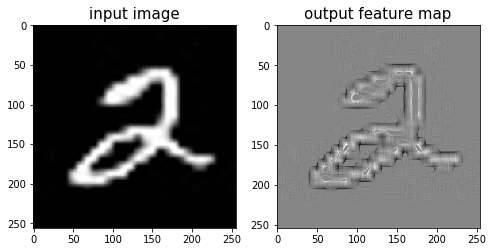

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 读取图片
img = Image.open('./number.jpg').resize((256,256))

# 设置卷积核参数
w = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]], dtype='float32')
# 创建卷积算子，卷积核大小为3x3，并使用上面的设置好的数值作为卷积核权重的初始化参数
conv = Conv2D(kernel_size=3, stride=1, padding=0, 
                weight_attr=paddle.ParamAttr(initializer=nn.initializer.Assign(value=w)))

# 将读入的图片转化为float32类型的numpy.ndarray
inputs = np.array(img).astype('float32')
print("bf to_tensor, inputs:",inputs)
# 将图片转为Tensor
inputs = paddle.to_tensor(inputs)
print("bf unsqueeze, inputs:",inputs)
inputs = paddle.unsqueeze(inputs, axis=0)
print("af unsqueeze, inputs:",inputs)
outputs = conv(inputs)
outputs = outputs.numpy()
# 可视化结果
plt.figure(figsize=(8, 4))
f = plt.subplot(121)
f.set_title('input image', fontsize=15)
plt.imshow(img)
f = plt.subplot(122)
f.set_title('output feature map', fontsize=15)
plt.imshow(outputs.squeeze(), cmap='gray')
plt.savefig('conv-vis.pdf')
plt.show()

从输出结果看，使用拉普拉斯算子，目标的边缘可以成功被检测出来。

## 5.2 卷积神经网络的基础算子

卷积神经网络是目前计算机视觉中使用最普遍的模型结构，如**图5.8** 所示，由$M$个卷积层和$b$个汇聚层组合作用在输入图片上，在网络的最后通常会加入$K$个全连接层。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/c08f9a5599ae4f9d8eedb0131c54af859fcfaae003224bc6b247d60391b2b102" width = "1000"></center>
<center><br>图5.8：卷积神经网络经典结构</br></center>

从上图可以看出，卷积网络是由多个基础的算子组合而成。下面我们先实现卷积网络的两个基础算子：卷积层算子和汇聚层算子。

###  5.2.1 卷积算子

卷积层是指用卷积操作来实现神经网络中一层。为了提取不同种类的特征，通常会使用多个卷积核一起进行特征提取。

####  5.2.1.1 多通道卷积

在前面介绍的二维卷积运算中，卷积的输入数据是二维矩阵。但实际应用中，一幅大小为$M\times N$的图片中的每个像素的特征表示不仅仅只有灰度值的标量，通常有多个特征，可以表示为$D$维的向量，比如RGB三个通道的特征向量。因此，图像上的卷积操作的输入数据通常是一个三维张量，分别对应了图片的高度$M$、宽度$N$和深度$D$，其中深度$D$通常也被称为**输入通道数**$D$。如果输入如果是灰度图像，则输入通道数为1；如果输入是彩色图像，分别有$R、G、B$三个通道，则输入通道数为3。

此外，由于具有单个核的卷积每次只能提取一种类型的特征，即输出一张大小为$U\times V$的**特征图**（Feature Map）。而在实际应用中，我们也希望每一个卷积层能够提取多种不同类型的特征，所以一个卷积层通常会组合多个不同的卷积核来提取特征，经过卷积运算后会输出多张特征图，不同的特征图对应不同类型的特征。输出特征图的个数通常将其称为**输出通道数**$P$。

------
**说明：**

《神经网络与深度学习》将Feature Map翻译为“特征映射”，这里翻译为“特征图”。

------

假设一个卷积层的输入特征图$\mathbf X\in \mathbb{R}^{D\times M\times N}$，其中$(M,N)$为特征图的尺寸，$D$代表通道数；卷积核为$\mathbf W\in \mathbb{R}^{P\times D\times U\times V}$，其中$(U,V)$为卷积核的尺寸，$D$代表输入通道数，$P$代表输出通道数。

------
**说明：**

在实践中，根据目前深度学习框架中张量的组织和运算性质，这里特征图的大小为$D\times M\times N$，和《神经网络与深度学习》中$M\times N \times D$的定义并不一致。
相应地，卷积核$W$的大小为$\mathbb{R}^{P\times D\times U\times V}$。

------

**一张输出特征图的计算**

对于$D$个输入通道，分别对每个通道的特征图$\mathbf X^d$设计一个二维卷积核$\mathbf W^{p,d}$，并与对应的输入特征图$\mathbf X^d$进行卷积运算，再将得到的$D$个结果进行加和，得到一张输出特征图$\mathbf Z^p$。计算方式如下：

$$
\mathbf Z^p = \sum_{d=1}^D \mathbf W^{p,d} \otimes \mathbf X^d + b^p，（5.18）
$$

$$
\mathbf Y^p = f(\mathbf Z^p)。（5.19）
$$

其中$p$表示输出特征图的索引编号，$\mathbf W^{p,d} \in \mathbb{R}^{U\times V}$为二维卷积核，$b^p$为标量偏置，$f(·)$为非线性激活函数，一般用ReLU函数。

*******

说明：

在代码实现时，通常将非线性激活函数放在卷积层算子外部。

*******

公式（5.13）对应的可视化如**图5.9**所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/d4d1434e62154505a56259d09c9b6e072f8331830c2b4ffc97b5d7bd0181b075" width = "600"></center>
<center><br>图5.9：多输入通道的卷积运算 </br></center>
<br></br>

**多张输出特征图的计算**

对于大小为$D\times M\times N$的输入特征图，每一个输出特征图都需要一组大小为$\mathbf W\in \mathbb{R}^{D\times U\times V}$的卷积核进行卷积运算。使用$P$组卷积核分布进行卷积运算，得到$P$个输出特征图$\mathbf Y^1, \mathbf Y^2,\cdots,\mathbf Y^P$。然后将$P$个输出特征图进行拼接，获得大小为$P\times M' \times N'$的多通道输出特征图。上面计算方式的可视化如下**图5.10**所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/7a75788ae8d54f22882590a0923f5dd28bca6e120b1a4431abe122980d06224f" width = "600"></center>
<center><br>图5.10：多输出通道的卷积运算 </br></center>
<br></br>

#### 5.2.1.2 多通道卷积层算子

根据上面的公式，多通道卷积卷积层的代码实现如下：

In [ ]:
class Conv2D(nn.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                    weight_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=1.0)),
                    bias_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=0.0))):
        super(Conv2D, self).__init__()
        # 创建卷积核
        self.weight = paddle.create_parameter(shape=[out_channels, in_channels, kernel_size,kernel_size],
                                                dtype='float32',
                                                attr=weight_attr)
        # 创建偏置
        self.bias = paddle.create_parameter(shape=[out_channels, 1],
                                                dtype='float32',
                                                attr=bias_attr)
        self.stride = stride
        self.padding = padding
        # 输入通道数
        self.in_channels = in_channels
        # 输出通道数
        self.out_channels = out_channels

    # 基础卷积运算
    def single_forward(self, X, weight):
        # 零填充
        new_X = paddle.zeros([X.shape[0], X.shape[1]+2*self.padding, X.shape[2]+2*self.padding])
        new_X[:, self.padding:X.shape[1]+self.padding, self.padding:X.shape[2]+self.padding] = X
        u, v = weight.shape
        output_w = (new_X.shape[1] - u) // self.stride + 1
        output_h = (new_X.shape[2] - v) // self.stride + 1
        output = paddle.zeros([X.shape[0], output_w, output_h])
        for i in range(0, output.shape[1]):
            for j in range(0, output.shape[2]):
                output[:, i, j] = paddle.sum(
                    new_X[:, self.stride*i:self.stride*i+u, self.stride*j:self.stride*j+v]*weight, 
                    axis=[1,2])
        return output

    def forward(self, inputs):
        """
        输入：
            - inputs：输入矩阵，shape=[B, D, M, N]
            - weights：P组二维卷积核，shape=[P, D, U, V]
            - bias：P个偏置，shape=[P, 1]
        """
        feature_maps = []
        # 进行多次多输入通道卷积运算
        p=0
        for w, b in zip(self.weight, self.bias): # P个(w,b),每次计算一个特征图Zp
            multi_outs = []
            # 循环计算每个输入特征图对应的卷积结果
            for i in range(self.in_channels):
                single = self.single_forward(inputs[:,i,:,:], w[i])
                multi_outs.append(single)
                # print("Conv2D in_channels:",self.in_channels,"i:",i,"single:",single.shape)
            # 将所有卷积结果相加
            feature_map = paddle.sum(paddle.stack(multi_outs), axis=0) + b #Zp
            feature_maps.append(feature_map)
            # print("Conv2D out_channels:",self.out_channels, "p:",p,"feature_map:",feature_map.shape)
            p+=1
        # 将所有Zp进行堆叠
        out = paddle.stack(feature_maps, 1) 
        return out

inputs = paddle.to_tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]]])
conv2d = Conv2D(in_channels=2, out_channels=3, kernel_size=2)
print("inputs shape:",inputs.shape)
outputs = conv2d(inputs)
print("Conv2D outputs shape:",outputs.shape)

# 比较与paddle API运算结果
conv2d_paddle = nn.Conv2D(in_channels=2, out_channels=3, kernel_size=2,
                            weight_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=1.0)),
                            bias_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=0.0)))
outputs_paddle = conv2d_paddle(inputs)
# 自定义算子运算结果
print('Conv2D outputs:', outputs)
# paddle API运算结果
print('nn.Conv2D outputs:', outputs_paddle)

inputs shape: [1, 2, 3, 3]
Conv2D outputs shape: [1, 3, 2, 2]
Conv2D outputs: Tensor(shape=[1, 3, 2, 2], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [[[[20., 28.],
          [44., 52.]],

         [[20., 28.],
          [44., 52.]],

         [[20., 28.],
          [44., 52.]]]])
nn.Conv2D outputs: Tensor(shape=[1, 3, 2, 2], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [[[[20., 28.],
          [44., 52.]],

         [[20., 28.],
          [44., 52.]],

         [[20., 28.],
          [44., 52.]]]])


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


#### 5.2.1.3 卷积算子的参数量和计算量

**参数量**

对于大小为$D\times M\times N$的输入特征图，使用$P$组大小为$\mathbf W\in \mathbb{R}^{D\times U\times V}$的卷积核进行卷积运算，参数量计算方式为：

$$
parameters = P \times D \times U \times V + P.（5.20）
$$

其中，最后的$P$代表偏置个数。例如：输入特征图大小为$3\times 32\times 32$，使用$6$组大小为$3\times 3\times 3$的卷积核进行卷积运算，参数量为：
$$
parameters = 6 \times 3 \times 3 \times 3 + 6= 168.
$$

**计算量**

对于大小为$D\times M\times N$的输入特征图，使用$P$组大小为$\mathbf W\in \mathbb{R}^{D\times U\times V}$的卷积核进行卷积运算，计算量计算方式为：

$$FLOPs=M'\times N'\times P\times D\times U\times V + M'\times N'\times P。（5.21）$$

其中$M'\times N'\times P$代表加偏置的计算量，即输出特征图上每个点都要与$P$组卷积核$\mathbf W\in \mathbb{R}^{D\times U\times V}$进行$U\times V\times D$次乘法运算后再加上偏置。比如对于输入特征图大小为$3\times 32\times 32$，使用$6$组大小为$3\times 3\times 3$的卷积核进行卷积运算，计算量为：

$$FLOPs=M'\times N'\times P\times D\times U\times V + M'\times N'\times P= 30\times 30\times 3\times 3\times 6\times 3 + 30\times 30\times 6= 151200$$

### 5.2.2 汇聚层算子

**汇聚层**的作用是进行特征选择，降低特征数量，从而减少参数数量。由于汇聚之后特征图会变得更小，如果后面连接的是全连接层，可以有效地减小神经元的个数，节省存储空间并提高计算效率。

常用的汇聚方法有两种，分别是：平均汇聚和最大汇聚。

* 平均汇聚：将输入特征图划分为$2\times2$大小的区域，对每个区域内的神经元活性值取平均值作为这个区域的表示；
* 最大汇聚：使用输入特征图的每个子区域内所有神经元的最大活性值作为这个区域的表示。

**图5.11** 给出了两种汇聚层的示例。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/d55501bb93914955b1c262a00201f8bcc6abf632085e48e3b37aac5f064a4e1c" width = "600"></center>
<center><br>图5.11：汇聚层 </br></center>
<br></br>

汇聚层输出的计算尺寸与卷积层一致，对于一个输入矩阵$\mathbf X\in\Bbb{R}^{M\times N}$和一个运算区域大小为$U\times V$的汇聚层，步长为$S$，对输入矩阵进行零填充，那么最终输出矩阵大小则为

$$M' = \frac{M + 2P - U}{S} + 1,（5.20）$$
$$N' = \frac{N + 2P - V}{S} + 1.（5.21）$$

由于过大的采样区域会急剧减少神经元的数量，也会造成过多的信息丢失。目前，在卷积神经网络中比较典型的汇聚层是将每个输入特征图划分为$2\times2$大小的不重叠区域，然后使用最大汇聚的方式进行下采样。

由于汇聚是使用某一位置的相邻输出的总体统计特征代替网络在该位置的输出，所以其好处是当输入数据做出少量平移时，经过汇聚运算后的大多数输出还能保持不变。比如：当识别一张图像是否是人脸时，我们需要知道人脸左边有一只眼睛，右边也有一只眼睛，而不需要知道眼睛的精确位置，这时候通过汇聚某一片区域的像素点来得到总体统计特征会显得很有用。这也就体现了汇聚层的**平移不变**特性。

**汇聚层的参数量和计算量**

由于汇聚层中没有参数，所以参数量为$0$；最大汇聚中，没有乘加运算，所以计算量为$0$，而平均汇聚中，输出特征图上每个点都对应了一次求平均运算。

使用飞桨实现一个简单的汇聚层，代码实现如下：

In [ ]:
class Pool2D(nn.Layer):
    def __init__(self, size=(2,2), mode='max', stride=1):
        super(Pool2D, self).__init__()
        # 汇聚方式
        self.mode = mode
        self.h, self.w = size
        self.stride = stride

    def forward(self, x):
        output_w = (x.shape[2] - self.w) // self.stride + 1
        output_h = (x.shape[3] - self.h) // self.stride + 1
        output = paddle.zeros([x.shape[0], x.shape[1], output_w, output_h])
        # 汇聚
        for i in range(output.shape[2]):
            for j in range(output.shape[3]):
                # 最大汇聚
                if self.mode == 'max':
                    output[:, :, i, j] = paddle.max(
                        x[:, :, self.stride*i:self.stride*i+self.w, self.stride*j:self.stride*j+self.h], 
                        axis=[2,3])
                # 平均汇聚
                elif self.mode == 'avg':
                    output[:, :, i, j] = paddle.mean(
                        x[:, :, self.stride*i:self.stride*i+self.w, self.stride*j:self.stride*j+self.h], 
                        axis=[2,3])
        
        return output

inputs = paddle.to_tensor([[[[1.,2.,3.,4.],[5.,6.,7.,8.],[9.,10.,11.,12.],[13.,14.,15.,16.]]]])
pool2d = Pool2D(stride=2)
outputs = pool2d(inputs)
print("input: {}, \noutput: {}".format(inputs.shape, outputs.shape))

# 比较Maxpool2D与paddle API运算结果
maxpool2d_paddle = nn.MaxPool2D(kernel_size=(2,2), stride=2)
outputs_paddle = maxpool2d_paddle(inputs)
# 自定义算子运算结果
print('Maxpool2D outputs:', outputs)
# paddle API运算结果
print('nn.Maxpool2D outputs:', outputs_paddle)

# 比较Avgpool2D与paddle API运算结果
avgpool2d_paddle = nn.AvgPool2D(kernel_size=(2,2), stride=2)
outputs_paddle = avgpool2d_paddle(inputs)
pool2d = Pool2D(mode='avg', stride=2)
outputs = pool2d(inputs)
# 自定义算子运算结果
print('Avgpool2D outputs:', outputs)
# paddle API运算结果
print('nn.Avgpool2D outputs:', outputs_paddle)

input: [1, 1, 4, 4], 
output: [1, 1, 2, 2]
Maxpool2D outputs: Tensor(shape=[1, 1, 2, 2], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [[[[6. , 8. ],
          [14., 16.]]]])
nn.Maxpool2D outputs: Tensor(shape=[1, 1, 2, 2], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [[[[6. , 8. ],
          [14., 16.]]]])
Avgpool2D outputs: Tensor(shape=[1, 1, 2, 2], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [[[[3.50000000 , 5.50000000 ],
          [11.50000000, 13.50000000]]]])
nn.Avgpool2D outputs: Tensor(shape=[1, 1, 2, 2], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [[[[3.50000000 , 5.50000000 ],
          [11.50000000, 13.50000000]]]])


## 5.3 基于LeNet实现手写体数字识别实验

在本节中，我们实现经典卷积网络LeNet-5，并进行手写体数字识别任务。

### 5.3.1 数据

手写体数字识别是计算机视觉中最常用的图像分类任务，让计算机识别出给定图片中的手写体数字（0-9共10个数字）。由于手写体风格差异很大，因此手写体数字识别是具有一定难度的任务。

我们采用常用的手写数字识别数据集：**MNIST数据集**。MNIST数据集是计算机视觉领域的经典入门数据集，包含了60,000个训练样本和10,000个测试样本。这些数字已经过尺寸标准化并位于图像中心，图像是固定大小($28\times28$像素)。**图5.12**给出了部分样本的示例。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/53774cf008e941d3b93ce2b8731a1089fc64539bebd347e3a255c2d8fb5ec1a9" width="600" hegiht="" ></center>
<center><br>图5.12：MNIST数据集示例</br></center>
<br></br>

为了节省训练时间，本节选取MNIST数据集的一个子集进行后续实验，数据集的划分为：

* 训练集：1,000条样本
* 验证集：200条样本
* 测试集：200条样本

MNIST数据集分为train_set、dev_set和test_set三个数据集，每个数据集含两个列表分别存放了图片数据以及标签数据。比如train_set包含：

* **图片数据**：[1 000, 784]的二维列表，包含1 000张图片。每张图片用一个长度为784的向量表示，内容是 $28\times 28$ 尺寸的像素灰度值（黑白图片）。
* **标签数据**：[1 000, 1]的列表，表示这些图片对应的分类标签，即0~9之间的数字。

观察数据集分布情况，代码实现如下：

In [ ]:
import json
import gzip

# 打印并观察数据集分布情况
train_set, dev_set, test_set = json.load(gzip.open('./mnist.json.gz'))
train_images, train_labels = train_set[0][:1000], train_set[1][:1000]
dev_images, dev_labels = dev_set[0][:200], dev_set[1][:200]
test_images, test_labels = test_set[0][:200], test_set[1][:200]
train_set, dev_set, test_set = [train_images, train_labels], [dev_images, dev_labels], [test_images, test_labels]
print('Length of train/dev/test set:{}/{}/{}'.format(len(train_set[0]), len(dev_set[0]), len(test_set[0])))

Length of train/dev/test set:1000/200/200


可视化观察其中的一张样本以及对应的标签，代码如下所示：

The number in the picture is 5


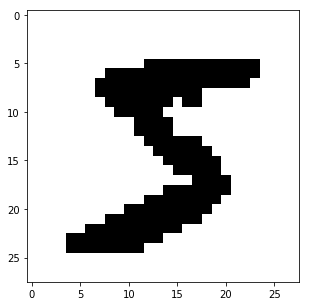

In [ ]:
image, label = train_set[0][0], train_set[1][0]
image, label = np.array(image).astype('float32'), int(label)
# 原始图像数据为长度784的行向量，需要调整为[28,28]大小的图像
image = np.reshape(image, [28,28])
image = Image.fromarray(image.astype('uint8'), mode='L')
print("The number in the picture is {}".format(label))
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.savefig('conv-number5.pdf')

#### 5.3.1.1 数据预处理

图像分类网络对输入图片的格式、大小有一定的要求，数据输入模型前，需要对数据进行预处理操作，使图片满足网络训练以及预测的需要。本实验主要应用了如下方法：

*  调整图片大小：LeNet网络对输入图片大小的要求为 $32\times 32$ ，而MNIST数据集中的原始图片大小却是 $28\times 28$ ，这里为了符合网络的结构设计，将其调整为$32 \times 32$；
*  规范化： 通过规范化手段，把输入图像的分布改变成均值为0，标准差为1的标准正态分布，使得最优解的寻优过程明显会变得平缓，训练过程更容易收敛。

*******

在飞桨中，提供了部分视觉领域的高层API，可以直接调用API实现简单的图像处理操作。通过调用`paddle.vision.transforms.Resize`调整大小；调用`paddle.vision.transforms.Normalize`进行标准化处理；使用`paddle.vision.transforms.Compose`将两个预处理操作进行拼接。

*******

代码实现如下：

In [ ]:
from paddle.vision.transforms import Compose, Resize, Normalize

# 数据预处理
transforms = Compose([Resize(32), Normalize(mean=[127.5], std=[127.5], data_format='CHW')])

将原始的数据集封装为Dataset类，以便DataLoader调用。

In [ ]:
import random
import paddle.io as io

class MNIST_dataset(io.Dataset):
    def __init__(self, dataset, transforms, mode='train'):
        self.mode = mode
        self.transforms =transforms
        self.dataset = dataset

    def __getitem__(self, idx):
        # 获取图像和标签
        image, label = self.dataset[0][idx], self.dataset[1][idx]
        image, label = np.array(image).astype('float32'), int(label)
        image = np.reshape(image, [28,28])
        image = Image.fromarray(image.astype('uint8'), mode='L')
        image = self.transforms(image)

        return image, label

    def __len__(self):
        return len(self.dataset[0])

In [ ]:
# 固定随机种子
random.seed(0)
# 加载 mnist 数据集
train_dataset = MNIST_dataset(dataset=train_set, transforms=transforms, mode='train')
test_dataset = MNIST_dataset(dataset=test_set, transforms=transforms, mode='test')
dev_dataset = MNIST_dataset(dataset=dev_set, transforms=transforms, mode='dev')

### 5.3.2 模型构建

LeNet-5虽然提出的时间比较早，但它是一个非常成功的神经网络模型。基于LeNet-5的手写数字识别系统在20世纪90年代被美国很多银行使用，用来识别支票上面的手写数字。LeNet-5的网络结构如**图5.13**所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/448b1f120a2e4890bae4589d213c0ab36f71b8d9d6204998a6cceddaabbe9ab5" width="600" hegiht="" ></center>
<center><br>图5.13：LeNet-5网络结构</br></center>
<br></br>

我们使用上面定义的卷积层算子和汇聚层算子构建一个LeNet-5模型。

************

  这里的LeNet-5和原始版本有4点不同：
1. C3层没有使用连接表来减少卷积数量。
1. 汇聚层使用了简单的平均汇聚，没有引入权重和偏置参数以及非线性激活函数。
1. 卷积层的激活函数使用ReLU函数。
1. 最后的输出层为一个全连接线性层。

************

网络共有7层，包含3个卷积层、2个汇聚层以及2个全连接层的简单卷积神经网络接，受输入图像大小为$32\times 32=1\, 024$，输出对应10个类别的得分。
具体实现如下：

In [ ]:
import paddle.nn.functional as F

class Model_LeNet(nn.Layer):
    def __init__(self, in_channels, num_classes=10):
        super(Model_LeNet, self).__init__()
        # 卷积层：输出通道数为6，卷积核大小为5×5
        self.conv1 = Conv2D(in_channels=in_channels, out_channels=6, kernel_size=5, weight_attr=paddle.ParamAttr())
        # 汇聚层：汇聚窗口为2×2，步长为2
        self.pool2 = Pool2D(size=(2,2), mode='max', stride=2)
        # 卷积层：输入通道数为6，输出通道数为16，卷积核大小为5×5，步长为1
        self.conv3 = Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1, weight_attr=paddle.ParamAttr())
        # 汇聚层：汇聚窗口为2×2，步长为2
        self.pool4 = Pool2D(size=(2,2), mode='avg', stride=2)
        # 卷积层：输入通道数为16，输出通道数为120，卷积核大小为5×5
        self.conv5 = Conv2D(in_channels=16, out_channels=120, kernel_size=5, stride=1, weight_attr=paddle.ParamAttr())
        # 全连接层：输入神经元为120，输出神经元为84
        self.linear6 = nn.Linear(120, 84)
        # 全连接层：输入神经元为84，输出神经元为类别数
        self.linear7 = nn.Linear(84, num_classes)

    def forward(self, x):
        # C1：卷积层+激活函数
        output = F.relu(self.conv1(x))
        # S2：汇聚层
        output = self.pool2(output)
        # C3：卷积层+激活函数
        output = F.relu(self.conv3(output))
        # S4：汇聚层
        output = self.pool4(output)
        # C5：卷积层+激活函数
        output = F.relu(self.conv5(output))
        # 输入层将数据拉平[B,C,H,W] -> [B,CxHxW]
        output = paddle.squeeze(output, axis=[2,3])
        # F6：全连接层
        output = F.relu(self.linear6(output))
        # F7：全连接层
        output = self.linear7(output)
        return output

下面测试一下上面的LeNet-5模型，构造一个形状为 [1,1,32,32]的输入数据送入网络，观察每一层特征图的形状变化。代码实现如下：

In [ ]:
# 这里用np.random创建一个随机数组作为输入数据
inputs = np.random.randn(*[1,1,32,32])
inputs = inputs.astype('float32')

# 创建Model_LeNet类的实例，指定模型名称和分类的类别数目
model = Model_LeNet(in_channels=1, num_classes=10)
# 通过调用LeNet从基类继承的sublayers()函数，查看LeNet中所包含的子层
print(model.sublayers())
x = paddle.to_tensor(inputs)
for item in model.sublayers():
    # item是LeNet类中的一个子层
    # 查看经过子层之后的输出数据形状
    try:
        x = item(x)
    except:
        # 如果是最后一个卷积层输出，需要展平后才可以送入全连接层
        x = paddle.reshape(x, [x.shape[0], -1])
        x = item(x)
    if len(item.parameters())==2:
        # 查看卷积和全连接层的数据和参数的形状，
        # 其中item.parameters()[0]是权重参数w，item.parameters()[1]是偏置参数b
        print(item.full_name(), x.shape, item.parameters()[0].shape, 
                item.parameters()[1].shape)
    else:
        # 汇聚层没有参数
        print(item.full_name(), x.shape)

[Conv2D(), Pool2D(), Conv2D(), Pool2D(), Conv2D(), Linear(in_features=120, out_features=84, dtype=float32), Linear(in_features=84, out_features=10, dtype=float32)]
conv2d_6 [1, 6, 28, 28] [6, 1, 5, 5] [6, 1]
pool2d_2 [1, 6, 14, 14]
conv2d_7 [1, 16, 10, 10] [16, 6, 5, 5] [16, 1]
pool2d_3 [1, 16, 5, 5]
conv2d_8 [1, 120, 1, 1] [120, 16, 5, 5] [120, 1]
linear_0 [1, 84] [120, 84] [84]
linear_1 [1, 10] [84, 10] [10]


从输出结果看，
* 对于大小为$32 \times32$的单通道图像，先用6个大小为$5 \times5$的卷积核对其进行卷积运算，输出为6个$28 \times28$大小的特征图；
* 6个$28 \times28$大小的特征图经过大小为$2 \times2$，步长为2的汇聚层后，输出特征图的大小变为$14 \times14$；
* 6个$14 \times14$大小的特征图再经过16个大小为$5 \times5$的卷积核对其进行卷积运算，得到16个$10 \times10$大小的输出特征图；
* 16个$10 \times10$大小的特征图经过大小为$2 \times2$，步长为2的汇聚层后，输出特征图的大小变为$5 \times5$；
* 16个$5 \times5$大小的特征图再经过120个大小为$5 \times5$的卷积核对其进行卷积运算，得到120个$1 \times1$大小的输出特征图；
* 此时，将特征图展平成1维，则有120个像素点，经过输入神经元个数为120，输出神经元个数为84的全连接层后，输出的长度变为84。
* 再经过一个全连接层的计算，最终得到了长度为类别数的输出结果。

考虑到自定义的`Conv2D`和`Pool2D`算子中包含多个`for`循环，所以运算速度比较慢。飞桨框架中，针对卷积层算子和汇聚层算子进行了速度上的优化，这里基于`paddle.nn.Conv2D`、`paddle.nn.MaxPool2D`和`paddle.nn.AvgPool2D`构建LeNet-5模型，对比与上边实现的模型的运算速度。代码实现如下：

In [ ]:
class Paddle_LeNet(nn.Layer):
    def __init__(self, in_channels, num_classes=10):
        super(Paddle_LeNet, self).__init__()
        # 卷积层：输出通道数为6，卷积核大小为5*5
        self.conv1 = nn.Conv2D(in_channels=in_channels, out_channels=6, kernel_size=5)
        # 汇聚层：汇聚窗口为2*2，步长为2
        self.pool2 = nn.MaxPool2D(kernel_size=2, stride=2)
        # 卷积层：输入通道数为6，输出通道数为16，卷积核大小为5*5
        self.conv3 = nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5)
        # 汇聚层：汇聚窗口为2*2，步长为2
        self.pool4 = nn.AvgPool2D(kernel_size=2, stride=2)
        # 卷积层：输入通道数为16，输出通道数为120，卷积核大小为5*5
        self.conv5 = nn.Conv2D(in_channels=16, out_channels=120, kernel_size=5)
        # 全连接层：输入神经元为120，输出神经元为84
        self.linear6 = nn.Linear(in_features=120, out_features=84)
        # 全连接层：输入神经元为84，输出神经元为类别数
        self.linear7 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        # C1：卷积层+激活函数
        output = F.relu(self.conv1(x))
        # S2：汇聚层
        output = self.pool2(output)
        # C3：卷积层+激活函数
        output = F.relu(self.conv3(output))
        # S4：汇聚层
        output = self.pool4(output)
        # C5：卷积层+激活函数
        output = F.relu(self.conv5(output))
        # 输入层将数据拉平[B,C,H,W] -> [B,CxHxW]
        output = paddle.squeeze(output, axis=[2,3])
        # F6：全连接层
        output = F.relu(self.linear6(output))
        # F7：全连接层
        output = self.linear7(output)
        return output

测试两个网络的运算速度。

In [ ]:
import time

# 这里用np.random创建一个随机数组作为测试数据
inputs = np.random.randn(*[1,1,32,32])
inputs = inputs.astype('float32')
x = paddle.to_tensor(inputs)

# 创建Model_LeNet类的实例，指定模型名称和分类的类别数目
model = Model_LeNet(in_channels=1, num_classes=10)
# 创建Paddle_LeNet类的实例，指定模型名称和分类的类别数目
paddle_model = Paddle_LeNet(in_channels=1, num_classes=10)

# 计算Model_LeNet类的运算速度
model_time = 0
for i in range(60):
    strat_time = time.time()
    out = model(x)
    end_time = time.time()
    # 预热10次运算，不计入最终速度统计
    if i < 10:
        continue
    model_time += (end_time - strat_time)
avg_model_time = model_time / 50
print('Model_LeNet speed:', avg_model_time, 's')

# 计算Paddle_LeNet类的运算速度
paddle_model_time = 0
for i in range(60):
    strat_time = time.time()
    paddle_out = paddle_model(x)
    end_time = time.time()
    # 预热10次运算，不计入最终速度统计
    if i < 10:
        continue
    paddle_model_time += (end_time - strat_time)
avg_paddle_model_time = paddle_model_time / 50

print('Paddle_LeNet speed:', avg_paddle_model_time, 's')

KeyboardInterrupt: 

这里还可以令两个网络加载同样的权重，测试一下两个网络的输出结果是否一致。

In [ ]:
# 这里用np.random创建一个随机数组作为测试数据
inputs = np.random.randn(*[1,1,32,32])
inputs = inputs.astype('float32')
x = paddle.to_tensor(inputs)

# 创建Model_LeNet类的实例，指定模型名称和分类的类别数目
model = Model_LeNet(in_channels=1, num_classes=10)
# 获取网络的权重
params = model.state_dict()
# 自定义Conv2D算子的bias参数形状为[out_channels, 1]
# paddle API中Conv2D算子的bias参数形状为[out_channels]
# 需要进行调整后才可以赋值
for key in params:
    if 'bias' in key:
        params[key] = params[key].squeeze()
# 创建Paddle_LeNet类的实例，指定模型名称和分类的类别数目
paddle_model = Paddle_LeNet(in_channels=1, num_classes=10)
# 将Model_LeNet的权重参数赋予给Paddle_LeNet模型，保持两者一致
paddle_model.set_state_dict(params)

# 打印结果保留小数点后6位
paddle.set_printoptions(6)
# 计算Model_LeNet的结果
output = model(x)
print('Model_LeNet output: ', output)
# 计算Paddle_LeNet的结果
paddle_output = paddle_model(x)
print('Paddle_LeNet output: ', paddle_output)

可以看到，输出结果是一致的。

这里还可以统计一下LeNet-5模型的参数量和计算量。

**参数量**

按照公式(5.18)进行计算，可以得到：
* 第一个卷积层的参数量为：$6 \times 1 \times 5 \times 5 + 6 = 156$；
* 第二个卷积层的参数量为：$16 \times 6 \times 5 \times 5 + 16 = 2416$；
* 第三个卷积层的参数量为：$120 \times 16 \times 5 \times 5 + 120= 48120$；
* 第一个全连接层的参数量为：$120 \times 84 + 84= 10164$；
* 第二个全连接层的参数量为：$84 \times 10 + 10= 850$；

所以，LeNet-5总的参数量为$61706$。

在飞桨中，还可以使用`paddle.summary`API自动计算参数量。

In [ ]:
model = Paddle_LeNet(in_channels=1, num_classes=10)
params_info = paddle.summary(model, (1, 1, 32, 32))
print(params_info)

可以看到，结果与公式推导一致。

**计算量**

按照公式(5.19)进行计算，可以得到：
* 第一个卷积层的计算量为：$28\times 28\times 5\times 5\times 6\times 1 + 28\times 28\times 6=122304$；
* 第二个卷积层的计算量为：$10\times 10\times 5\times 5\times 16\times 6 + 10\times 10\times 16=241600$；
* 第三个卷积层的计算量为：$1\times 1\times 5\times 5\times 120\times 16 + 1\times 1\times 120=48120$；
* 平均汇聚层的计算量为：$16\times 5\times 5=400$
* 第一个全连接层的计算量为：$120 \times 84 = 10080$；
* 第二个全连接层的计算量为：$84 \times 10 = 840$；

所以，LeNet-5总的计算量为$423344$。

在飞桨中，还可以使用`paddle.flops`API自动统计计算量。

In [ ]:
FLOPs = paddle.flops(model, (1, 1, 32, 32), print_detail=True)
print(FLOPs)

<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.pooling.AvgPool2D'>'s flops has been counted
<class 'paddle.nn.layer.common.Linear'>'s flops has been counted
+--------------+-----------------+-----------------+--------+--------+
|  Layer Name  |   Input Shape   |   Output Shape  | Params | Flops  |
+--------------+-----------------+-----------------+--------+--------+
|  conv2d_21   |  [1, 1, 32, 32] |  [1, 6, 28, 28] |  156   | 122304 |
| max_pool2d_3 |  [1, 6, 28, 28] |  [1, 6, 14, 14] |   0    |   0    |
|  conv2d_22   |  [1, 6, 14, 14] | [1, 16, 10, 10] |  2416  | 241600 |
| avg_pool2d_3 | [1, 16, 10, 10] |  [1, 16, 5, 5]  |   0    |  400   |
|  conv2d_23   |  [1, 16, 5, 5]  |  [1, 120, 1, 1] | 48120  | 48120  |
|  linear_10   |     [1, 120]    |     [1, 84]     | 10164  | 10080  |
|  linear_11   |     [1, 84]     |     [1, 10]     |  8

可以看到，结果与公式推导一致。

### 5.3.3 模型训练

使用交叉熵损失函数，并用随机梯度下降法作为优化器来训练LeNet-5网络。
用RunnerV3在训练集上训练5个epoch，并保存准确率最高的模型作为最佳模型。

In [16]:
import paddle.optimizer as opt
from nndl import RunnerV3, metric

paddle.seed(100)
# 学习率大小
lr = 0.1    
# 批次大小
batch_size = 64
# 加载数据
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = io.DataLoader(dev_dataset, batch_size=batch_size)
test_loader = io.DataLoader(test_dataset, batch_size=batch_size)
# 定义LeNet网络
# 自定义算子实现的LeNet-5
model = Model_LeNet(in_channels=1, num_classes=10)
# 飞桨API实现的LeNet-5
# model = Paddle_LeNet(in_channels=1, num_classes=10)
# 定义优化器
optimizer = opt.SGD(learning_rate=lr, parameters=model.parameters())
# 定义损失函数
loss_fn = F.cross_entropy
# 定义评价指标
metric = metric.Accuracy(is_logist=True)
# 实例化 RunnerV3 类，并传入训练配置。
runner = RunnerV3(model, optimizer, loss_fn, metric)
# 启动训练
log_steps = 15
eval_steps = 15
runner.train(train_loader, dev_loader, num_epochs=5, log_steps=log_steps, 
                eval_steps=eval_steps, save_path="best_model.pdparams")          

[Train] epoch: 0/5, step: 0/80, loss: 2.28455
[Train] epoch: 0/5, step: 15/80, loss: 1.93600
[Evaluate]  dev score: 0.38000, dev loss: 1.98255
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.38000
[Train] epoch: 1/5, step: 30/80, loss: 1.72429
[Evaluate]  dev score: 0.63500, dev loss: 1.56296
[Evaluate] best accuracy performence has been updated: 0.38000 --> 0.63500
[Train] epoch: 2/5, step: 45/80, loss: 0.87373
[Evaluate]  dev score: 0.72000, dev loss: 0.78202
[Evaluate] best accuracy performence has been updated: 0.63500 --> 0.72000
[Train] epoch: 3/5, step: 60/80, loss: 0.70869
[Evaluate]  dev score: 0.75000, dev loss: 0.60713
[Evaluate] best accuracy performence has been updated: 0.72000 --> 0.75000
[Train] epoch: 4/5, step: 75/80, loss: 0.42060
[Evaluate]  dev score: 0.87500, dev loss: 0.40498
[Evaluate] best accuracy performence has been updated: 0.75000 --> 0.87500
[Evaluate]  dev score: 0.75500, dev loss: 0.61064
[Train] Training done!


可视化观察训练集与验证集的损失变化情况。

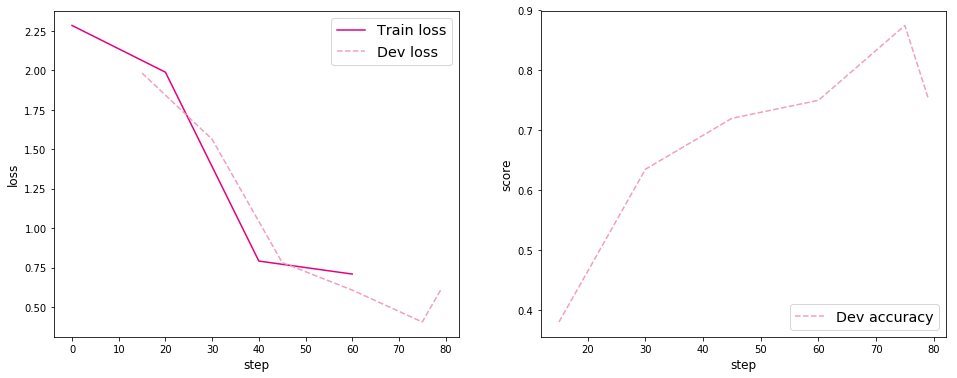

In [17]:
from nndl import plot_training_loss_acc
plot_training_loss_acc(runner, 'cnn-loss1.pdf')

### 5.3.4 模型评价

使用测试数据对在训练过程中保存的最佳模型进行评价，观察模型在测试集上的准确率以及损失变化情况。

In [18]:
# 加载最优模型
runner.load_model('best_model.pdparams')
# 模型评价
score, loss = runner.evaluate(test_loader)
print("[Test] accuracy/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] accuracy/loss: 0.8700/0.4423


### 5.3.5 模型预测

同样地，我们也可以使用保存好的模型，对测试集中的某一个数据进行模型预测，观察模型效果。

The true category is 2 and the predicted category is 2


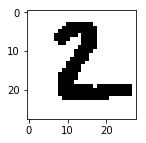

In [19]:
# 获取测试集中第一条数据
X, label = next(test_loader())
logits = runner.predict(X)
# 多分类，使用softmax计算预测概率
pred = F.softmax(logits)
# 获取概率最大的类别
pred_class = paddle.argmax(pred[1]).numpy()
label = label[1][0].numpy()
# 输出真实类别与预测类别
print("The true category is {} and the predicted category is {}".format(label[0], pred_class[0]))
# 可视化图片
plt.figure(figsize=(2, 2))
image, label = test_set[0][1], test_set[1][1]
image= np.array(image).astype('float32')
image = np.reshape(image, [28,28])
image = Image.fromarray(image.astype('uint8'), mode='L')
plt.imshow(image)
plt.savefig('cnn-number2.pdf')

## 5.4 基于残差网络的手写体数字识别实验

**残差网络**（Residual Network，ResNet）是在神经网络模型中给非线性层增加直连边的方式来缓解梯度消失问题，从而使训练深度神经网络变得更加容易。

在残差网络中，最基本的单位为**残差单元**。

假设$f(\mathbf x;\theta)$为一个或多个神经层，残差单元在$f()$的输入和输出之间加上一个**直连边**。

不同于传统网络结构中让网络$f(x;\theta)$去逼近一个目标函数$h(x)$，在残差网络中，将目标函数$h(x)$拆为了两个部分：恒等函数$x$和残差函数$h(x)-x$

$$
\mathrm{ResBlock}_f(\mathbf x) = f(\mathbf x;\theta) + \mathbf x,（5.22）
$$

其中$\theta$为可学习的参数。

一个典型的残差单元如**图5.14**所示，由多个级联的卷积层和一个跨层的直连边组成。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/cf14626bb6c54eb9840a7253975fdc995f165146c6324bdb8f9b943b96f57394" width = "200"></center>
<center><br>图5.14：残差单元结构</br></center>


一个残差网络通常有很多个残差单元堆叠而成。下面我们来构建一个在计算机视觉中非常典型的残差网络：ResNet18，并重复上一节中的手写体数字识别任务。

### 5.4.1 模型构建

在本节中，我们先构建ResNet18的残差单元，然后在组建完整的网络。

#### 5.4.1.1 残差单元

这里，我们实现一个算子`ResBlock`来构建残差单元，其中定义了`use_residual`参数，用于在后续实验中控制是否使用残差连接。


*******

残差单元包裹的非线性层的输入和输出形状大小应该一致。如果一个卷积层的输入特征图和输出特征图的通道数不一致，则其输出与输入特征图无法直接相加。为了解决上述问题，我们可以使用$1 \times 1$大小的卷积将输入特征图的通道数映射为与级联卷积输出特征图的一致通道数。

$1 \times 1$卷积：与标准卷积完全一样，唯一的特殊点在于卷积核的尺寸是$1 \times 1$，也就是不去考虑输入数据局部信息之间的关系，而把关注点放在不同通道间。通过使用$1 \times 1$卷积，可以起到如下作用：

* 实现信息的跨通道交互与整合。考虑到卷积运算的输入输出都是3个维度（宽、高、多通道），所以$1 \times 1$卷积实际上就是对每个像素点，在不同的通道上进行线性组合，从而整合不同通道的信息；
* 对卷积核通道数进行降维和升维，减少参数量。经过$1 \times 1$卷积后的输出保留了输入数据的原有平面结构，通过调控通道数，从而完成升维或降维的作用；
* 利用$1 \times 1$卷积后的非线性激活函数，在保持特征图尺寸不变的前提下，大幅增加非线性。

*******

In [21]:
class ResBlock(nn.Layer):
    def __init__(self, in_channels, out_channels, stride=1, use_residual=True):
        """
        残差单元
        输入：
            - in_channels：输入通道数
            - out_channels：输出通道数
            - stride：残差单元的步长，通过调整残差单元中第一个卷积层的步长来控制
            - use_residual：用于控制是否使用残差连接
        """
        super(ResBlock, self).__init__()
        self.stride = stride
        self.use_residual = use_residual
        # 第一个卷积层，卷积核大小为3×3，可以设置不同输出通道数以及步长
        self.conv1 = nn.Conv2D(in_channels, out_channels, 3, padding=1, stride=self.stride, bias_attr=False)
        # 第二个卷积层，卷积核大小为3×3，不改变输入特征图的形状，步长为1
        self.conv2 = nn.Conv2D(out_channels, out_channels, 3, padding=1, bias_attr=False)
        
        # 如果conv2的输出和此残差块的输入数据形状不一致，则use_1x1conv = True
        # 当use_1x1conv = True，添加1个1x1的卷积作用在输入数据上，使其形状变成跟conv2一致
        if in_channels != out_channels or stride != 1:
            self.use_1x1conv = True
        else:
            self.use_1x1conv = False
        # 当残差单元包裹的非线性层输入和输出通道数不一致时，需要用1×1卷积调整通道数后再进行相加运算
        if self.use_1x1conv:
            self.shortcut = nn.Conv2D(in_channels, out_channels, 1, stride=self.stride, bias_attr=False)

        # 每个卷积层后会接一个批量规范化层，批量规范化的内容在7.5.1中会进行详细介绍
        self.bn1 = nn.BatchNorm2D(out_channels)
        self.bn2 = nn.BatchNorm2D(out_channels)
        if self.use_1x1conv:
            self.bn3 = nn.BatchNorm2D(out_channels)

    def forward(self, inputs):
        y = F.relu(self.bn1(self.conv1(inputs)))
        y = self.bn2(self.conv2(y))
        if self.use_residual:
            if self.use_1x1conv:  # 如果为真，对inputs进行1×1卷积，将形状调整成跟conv2的输出y一致
                shortcut = self.shortcut(inputs)
                shortcut = self.bn3(shortcut)
            else: # 否则直接将inputs和conv2的输出y相加
                shortcut = inputs
            y = paddle.add(shortcut, y)
        out = F.relu(y)
        return out

#### 5.4.1.2 残差网络的整体结构

残差网络就是将很多个残差单元串联起来构成的一个非常深的网络。ResNet18 的网络结构如**图5.16**所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/16cb9fe0d0704940a829be1722fd6273b85209f198d143efb221f760d5f87f64" width = "700"></center>
<center><br>图5.16：残差网络</br></center>

其中为了便于理解，可以将ResNet18网络划分为6个模块：

* 第一模块：包含了一个步长为2，大小为$7 \times 7$的卷积层，卷积层的输出通道数为64，卷积层的输出经过批量归一化、ReLU激活函数的处理后，接了一个步长为2的$3 \times 3$的最大汇聚层；
* 第二模块：包含了两个残差单元，经过运算后，输出通道数为64，特征图的尺寸保持不变；
* 第三模块：包含了两个残差单元，经过运算后，输出通道数为128，特征图的尺寸缩小一半；
* 第四模块：包含了两个残差单元，经过运算后，输出通道数为256，特征图的尺寸缩小一半；
* 第五模块：包含了两个残差单元，经过运算后，输出通道数为512，特征图的尺寸缩小一半；
* 第六模块：包含了一个全局平均汇聚层，将特征图变为$1 \times 1$的大小，最终经过全连接层计算出最后的输出。

ResNet18模型的代码实现如下：

定义模块一。

In [22]:
def make_first_module(in_channels):
    # 模块一：7*7卷积、批量规范化、汇聚
    m1 = nn.Sequential(nn.Conv2D(in_channels, 64, 7, stride=2, padding=3),
                    nn.BatchNorm2D(64), nn.ReLU(),
                    nn.MaxPool2D(kernel_size=3, stride=2, padding=1))
    return m1

定义模块二到模块五。

In [23]:
def resnet_module(input_channels, out_channels, num_res_blocks, stride=1, use_residual=True):
    blk = []
    # 根据num_res_blocks，循环生成残差单元
    for i in range(num_res_blocks):
        if i == 0: # 创建模块中的第一个残差单元
            blk.append(ResBlock(input_channels, out_channels,
                                stride=stride, use_residual=use_residual))
        else:      # 创建模块中的其他残差单元
            blk.append(ResBlock(out_channels, out_channels, use_residual=use_residual))
    return blk

封装模块二到模块五。

In [24]:
def make_modules(use_residual):
    # 模块二：包含两个残差单元，输入通道数为64，输出通道数为64，步长为1，特征图大小保持不变
    m2 = nn.Sequential(*resnet_module(64, 64, 2, stride=1, use_residual=use_residual))
    # 模块三：包含两个残差单元，输入通道数为64，输出通道数为128，步长为2，特征图大小缩小一半。
    m3 = nn.Sequential(*resnet_module(64, 128, 2, stride=2, use_residual=use_residual))
    # 模块四：包含两个残差单元，输入通道数为128，输出通道数为256，步长为2，特征图大小缩小一半。
    m4 = nn.Sequential(*resnet_module(128, 256, 2, stride=2, use_residual=use_residual))
    # 模块五：包含两个残差单元，输入通道数为256，输出通道数为512，步长为2，特征图大小缩小一半。
    m5 = nn.Sequential(*resnet_module(256, 512, 2, stride=2, use_residual=use_residual))
    return m2, m3, m4, m5

定义完整网络。

In [25]:
# 定义完整网络
class Model_ResNet18(nn.Layer):
    def __init__(self, in_channels=3, num_classes=10, use_residual=True):
        super(Model_ResNet18,self).__init__()
        m1 = make_first_module(in_channels)
        m2, m3, m4, m5 = make_modules(use_residual)
        # 封装模块一到模块6
        self.net = nn.Sequential(m1, m2, m3, m4, m5,
                        # 模块六：汇聚层、全连接层
                        nn.AdaptiveAvgPool2D(1), nn.Flatten(), nn.Linear(512, num_classes) )

    def forward(self, x):
        return self.net(x)

这里同样可以使用`paddle.summary`统计模型的参数量。

In [26]:
model = Model_ResNet18(in_channels=1, num_classes=10, use_residual=True)
params_info = paddle.summary(model, (1, 1, 32, 32))
print(params_info)

-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-22        [[1, 1, 32, 32]]     [1, 64, 16, 16]         3,200     
   BatchNorm2D-1     [[1, 64, 16, 16]]     [1, 64, 16, 16]          256      
      ReLU-1         [[1, 64, 16, 16]]     [1, 64, 16, 16]           0       
    MaxPool2D-3      [[1, 64, 16, 16]]      [1, 64, 8, 8]            0       
     Conv2D-23        [[1, 64, 8, 8]]       [1, 64, 8, 8]         36,864     
   BatchNorm2D-2      [[1, 64, 8, 8]]       [1, 64, 8, 8]           256      
     Conv2D-24        [[1, 64, 8, 8]]       [1, 64, 8, 8]         36,864     
   BatchNorm2D-3      [[1, 64, 8, 8]]       [1, 64, 8, 8]           256      
    ResBlock-1        [[1, 64, 8, 8]]       [1, 64, 8, 8]            0       
     Conv2D-25        [[1, 64, 8, 8]]       [1, 64, 8, 8]         36,864     
   BatchNorm2D-4      [[1, 64, 8, 8]]       [1, 64, 8, 8]     

使用`paddle.flops`统计模型的计算量。

In [27]:
FLOPs = paddle.flops(model, (1, 1, 32, 32), print_detail=True)
print(FLOPs)

<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.pooling.AdaptiveAvgPool2D'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.fluid.dygraph.nn.Flatten'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.common.Linear'>'s flops has been counted
+-----------------------+-----------------+-----------------+---------+---------+
|       Layer Name      |   Input Shape   |   Output Shape  |  Params |  Flops  |
+-----------------------+-----------------+-----------------+---------+---------+
|       conv2d_21       |  [1, 1, 32, 32] | [1, 64, 16, 16] |   3200  |  819200 |
|     batch_norm2d_0    | [1, 64, 16, 16] | [1, 64, 16, 16] |   256   |  32768  |
|        re_lu_0        | [1, 64, 

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:130: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


为了验证残差连接对深层卷积神经网络的训练可以起到促进作用，接下来先使用ResNet18（use_residual设置为False）进行手写数字识别实验，再添加残差连接（use_residual设置为True），观察实验对比效果。

### 5.4.2 没有残差连接的ResNet18

为了验证残差连接的效果，先使用没有残差连接的ResNet18进行实验。

#### 5.4.2.1 模型训练

使用训练集和验证集进行模型训练，共训练5个epoch。在实验中，保存准确率最高的模型作为最佳模型。代码实现如下

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


[Train] epoch: 0/5, step: 0/80, loss: 2.53809
[Train] epoch: 0/5, step: 15/80, loss: 1.82928
[Evaluate]  dev score: 0.18500, dev loss: 2.20912
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.18500
[Train] epoch: 1/5, step: 30/80, loss: 0.98511
[Evaluate]  dev score: 0.59000, dev loss: 1.35768
[Evaluate] best accuracy performence has been updated: 0.18500 --> 0.59000
[Train] epoch: 2/5, step: 45/80, loss: 0.62413
[Evaluate]  dev score: 0.72000, dev loss: 0.81154
[Evaluate] best accuracy performence has been updated: 0.59000 --> 0.72000
[Train] epoch: 3/5, step: 60/80, loss: 0.33644
[Evaluate]  dev score: 0.77000, dev loss: 0.68273
[Evaluate] best accuracy performence has been updated: 0.72000 --> 0.77000
[Train] epoch: 4/5, step: 75/80, loss: 0.16001
[Evaluate]  dev score: 0.81000, dev loss: 0.60809
[Evaluate] best accuracy performence has been updated: 0.77000 --> 0.81000
[Evaluate]  dev score: 0.79000, dev loss: 0.62241
[Train] Training done!


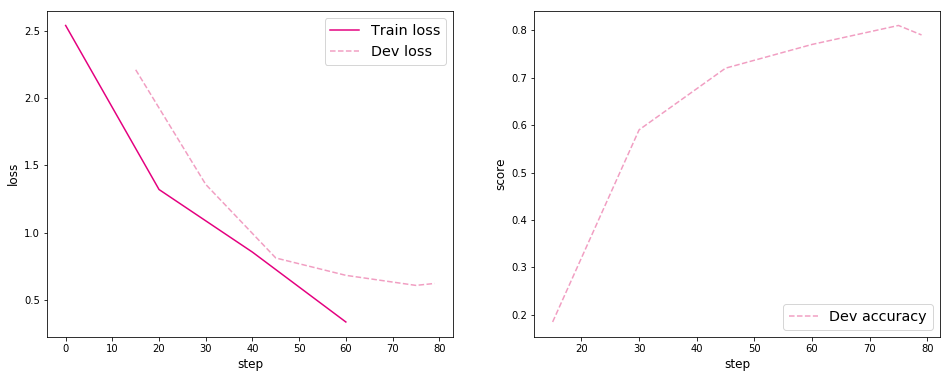

In [28]:
from nndl import plot

paddle.seed(100)
# 学习率大小
lr = 0.005  
# 批次大小
batch_size = 64
# 加载数据
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = io.DataLoader(dev_dataset, batch_size=batch_size)
test_loader = io.DataLoader(test_dataset, batch_size=batch_size)
# 定义网络，不使用残差结构的深层网络
model = Model_ResNet18(in_channels=1, num_classes=10, use_residual=False)
# 定义优化器
optimizer = opt.SGD(learning_rate=lr, parameters=model.parameters())
# 实例化RunnerV3
runner = RunnerV3(model, optimizer, loss_fn, metric)
# 启动训练
log_steps = 15
eval_steps = 15
runner.train(train_loader, dev_loader, num_epochs=5, log_steps=log_steps, 
            eval_steps=eval_steps, save_path="best_model.pdparams")
# 可视化观察训练集与验证集的Loss变化情况
plot_training_loss_acc(runner, 'cnn-loss2.pdf')

#### 5.4.2.2 模型评价

使用测试数据对在训练过程中保存的最佳模型进行评价，观察模型在测试集上的准确率以及损失情况。代码实现如下

In [29]:
# 加载最优模型
runner.load_model('best_model.pdparams')
# 模型评价
score, loss = runner.evaluate(test_loader)
print("[Test] accuracy/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] accuracy/loss: 0.8100/0.5841


从输出结果看，对比LeNet-5模型评价实验结果，网络层级加深后，训练效果不升反降。

### 5.4.3 带残差连接的ResNet18

#### 5.4.3.1 模型训练

使用带残差连接的ResNet18重复上面的实验，代码实现如下：

[Train] epoch: 0/5, step: 0/80, loss: 3.41889
[Train] epoch: 0/5, step: 15/80, loss: 0.81710
[Evaluate]  dev score: 0.53500, dev loss: 1.37067
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.53500
[Train] epoch: 1/5, step: 30/80, loss: 0.31470
[Evaluate]  dev score: 0.81500, dev loss: 0.55274
[Evaluate] best accuracy performence has been updated: 0.53500 --> 0.81500
[Train] epoch: 2/5, step: 45/80, loss: 0.02694
[Evaluate]  dev score: 0.87000, dev loss: 0.35305
[Evaluate] best accuracy performence has been updated: 0.81500 --> 0.87000
[Train] epoch: 3/5, step: 60/80, loss: 0.01007
[Evaluate]  dev score: 0.86000, dev loss: 0.31423
[Train] epoch: 4/5, step: 75/80, loss: 0.01729
[Evaluate]  dev score: 0.87000, dev loss: 0.31510
[Evaluate]  dev score: 0.86500, dev loss: 0.30383
[Train] Training done!


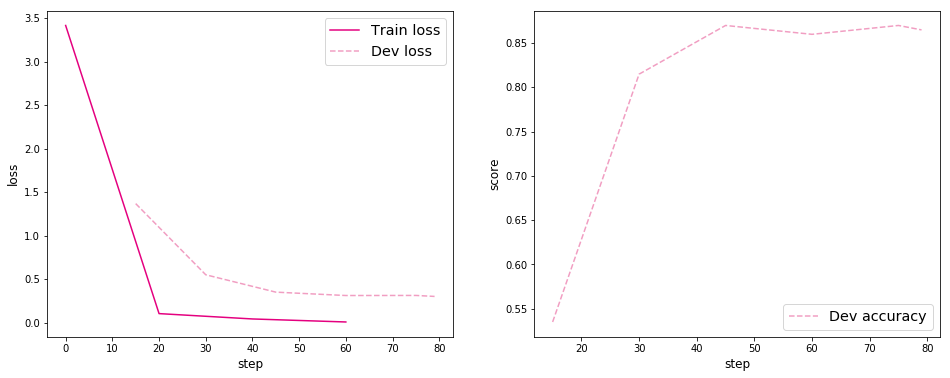

In [30]:
# 学习率大小
lr = 0.01  
# 批次大小
batch_size = 64
# 加载数据
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = io.DataLoader(dev_dataset, batch_size=batch_size)
test_loader = io.DataLoader(test_dataset, batch_size=batch_size)
# 定义网络，通过指定use_residual为True，使用残差结构的深层网络
model = Model_ResNet18(in_channels=1, num_classes=10, use_residual=True)
# 定义优化器
optimizer = opt.SGD(learning_rate=lr, parameters=model.parameters())
# 实例化RunnerV3
runner = RunnerV3(model, optimizer, loss_fn, metric)
# 启动训练
log_steps = 15
eval_steps = 15
runner.train(train_loader, dev_loader, num_epochs=5, log_steps=log_steps, 
            eval_steps=eval_steps, save_path="best_model.pdparams")

# 可视化观察训练集与验证集的Loss变化情况
plot_training_loss_acc(runner, 'cnn-loss3.pdf')

#### 5.4.3.2 模型评价

使用测试数据对在训练过程中保存的最佳模型进行评价，观察模型在测试集上的准确率以及损失情况。

In [31]:
# 加载最优模型
runner.load_model('best_model.pdparams')
# 模型评价
score, loss = runner.evaluate(test_loader)
print("[Test] accuracy/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] accuracy/loss: 0.8800/0.3523


添加了残差连接后，模型收敛曲线更平滑。
从输出结果看，和不使用残差连接的ResNet相比，添加了残差连接后，模型效果有了一定的提升。

### 5.4.4 与高层API实现版本的对比实验

对于Reset18这种比较经典的图像分类网络，飞桨高层API中都为大家提供了实现好的版本，大家可以不再从头开始实现。这里为高层API版本的resnet18模型和自定义的resnet18模型赋予相同的权重，并使用相同的输入数据，观察输出结果是否一致。

In [ ]:
from paddle.vision.models import resnet18
import warnings
#warnings.filterwarnings("ignore")

# 使用飞桨HAPI中实现的resnet18模型，该模型默认输入通道数为3，输出类别数1000
hapi_model = resnet18()
# 自定义的resnet18模型
model = Model_ResNet18(in_channels=3, num_classes=1000, use_residual=True)

# 获取网络的权重
params = hapi_model.state_dict()
# 用来保存参数名映射后的网络权重
new_params = {}
# 将参数名进行映射
for key in params:
    if 'layer' in key:
        if 'downsample.0' in key:
            new_params['net.' + key[5:8] + '.shortcut' + key[-7:]] = params[key]
        elif 'downsample.1' in key:
            new_params['net.' + key[5:8] + '.shorcutt' + key[23:]] = params[key]
        else:
            new_params['net.' + key[5:]] = params[key]
    elif 'conv1.weight' == key:
        new_params['net.0.0.weight'] = params[key]
    elif 'bn1' in key:
        new_params['net.0.1' + key[3:]] = params[key]
    elif 'fc' in key:
        new_params['net.7' + key[2:]] = params[key]

# 将飞桨HAPI中实现的resnet18模型的权重参数赋予自定义的resnet18模型，保持两者一致
model.set_state_dict(new_params)

# 这里用np.random创建一个随机数组作为测试数据
inputs = np.random.randn(*[1,3,32,32])
inputs = inputs.astype('float32')
x = paddle.to_tensor(inputs)

output = model(x)
hapi_out = hapi_model(x)

# 计算两个模型输出的差异
diff = output - hapi_out
# 取差异最大的值
max_diff = paddle.max(diff)
print(max_diff)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1441: UserWarning: Skip loading for net.0.0.bias. net.0.0.bias is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1441: UserWarning: Skip loading for net.2.0.bn3.weight. net.2.0.bn3.weight is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1441: UserWarning: Skip loading for net.2.0.bn3.bias. net.2.0.bn3.bias is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1441: UserWarning: Skip loading for net.2.0.bn3._mean. net.2.0.bn3._mean is not found in the pro

Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.])


可以看到，高层API版本的resnet18模型和自定义的resnet18模型输出结果是一致的，也就说明两个模型的实现完全一样。